Cristiano Colpo cristiano.colpo@studenti.unipd.it 2017898

Mattia Sandri mattia.sandri.1@studenti.unipd.it 2021425


# Final project MANAGEMENT AND ANALYSIS OF PHYSICS DATASET 
## Anomaly detection and Predictive maintence for industrial devices
### Anomaly Detection 1: Task 1

Perform some distributed analysis that allows the users to identify possible anomalies on the high number of turn on and off these engines (an anomaly happens even if just one of the engines of a device is turning on/off with high frequency)

In [1]:
from dask.distributed import Client
import dask
import dask.dataframe as dd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [22]:
client = Client(n_workers=1)
client

/home/mattia/.local/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44565 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:44565/status,
Dashboard: http://127.0.0.1:44565/status,Workers: 1
Total threads: 8,Total memory: 15.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35345,Workers: 1
Dashboard: http://127.0.0.1:44565/status,Total threads: 8
Started: Just now,Total memory: 15.57 GiB
Comm: tcp://127.0.0.1:46483,Total threads: 8
Dashboard: http://127.0.0.1:33073/status,Memory: 15.57 GiB
Nanny: tcp://127.0.0.1:43149,


In [23]:
df = dd.read_csv("dataset/dataset.csv")
df['when']=dd.to_datetime(df.when,unit='ms')

In [24]:
motors_data = df[(df["metric"] == "S117")|(df["metric"] =="S118")|(df["metric"] =="S169")|(df["metric"] =="S170")]
inizio = time.time()
groupby = motors_data.set_index("when").groupby("metric").apply(lambda df: df.resample("1min").max().dropna(),
                                                               meta={"hwid":"object",
                                                                     "metric":"object",
                                                                     "value":"object"
                                                                    }
                                                               ).compute()
print("{} secondi".format(time.time()-inizio))

274.27744364738464 secondi


In [5]:
groupby.index = groupby.index.droplevel(0)

In [6]:
changesOfState = dd.from_pandas(groupby, npartitions=3)

In [7]:
changesOfState = changesOfState.persist()

In [8]:
changesOfState_groupby = changesOfState.groupby("metric").apply(lambda df: df.assign(diff=df.value.diff(1)),
                                                               meta={"hwid":"object",
                                                                     "metric":"object",
                                                                     "value":"object",
                                                                     "diff":"object"
                                                                    }
                                                               ).compute()

In [9]:
changesOfState_s117 = changesOfState_groupby.loc["S117",:]["diff"].abs().dropna()
changesOfState_s118 = changesOfState_groupby.loc["S118",:]["diff"].abs().dropna()
changesOfState_s169 = changesOfState_groupby.loc["S169",:]["diff"].abs().dropna()
changesOfState_s170 = changesOfState_groupby.loc["S170",:]["diff"].abs().dropna()

In [10]:
NumberOfChangesOfState_s117 = changesOfState_s117.resample('1h').sum()
NumberOfChangesOfState_s118 = changesOfState_s118.resample('1h').sum()
NumberOfChangesOfState_s169 = changesOfState_s169.resample('1h').sum()
NumberOfChangesOfState_s170 = changesOfState_s170.resample('1h').sum()

In order to find the anomalies ("Salient Points") we used the 3 Sigma Rule: if the number of change of state are more than the mean number of change of state plus 3 times the standard deviation, we consider that part a "Salient Point"

In [11]:
salientPoints_s170 = NumberOfChangesOfState_s170[NumberOfChangesOfState_s170 > NumberOfChangesOfState_s170.mean()+3*NumberOfChangesOfState_s170.std()].dropna()
salientPoints_s169 = NumberOfChangesOfState_s169[NumberOfChangesOfState_s169 > NumberOfChangesOfState_s169.mean()+3*NumberOfChangesOfState_s169.std()].dropna()
salientPoints_s117 = NumberOfChangesOfState_s117[NumberOfChangesOfState_s117 > NumberOfChangesOfState_s117.mean()+3*NumberOfChangesOfState_s117.std()].dropna()
salientPoints_s118 = NumberOfChangesOfState_s118[NumberOfChangesOfState_s118 > NumberOfChangesOfState_s118.mean()+3*NumberOfChangesOfState_s118.std()].dropna()

In [12]:
salientPoints = pd.DataFrame(pd.concat([salientPoints_s117, salientPoints_s118, salientPoints_s169, salientPoints_s170])).sort_values(by="when")

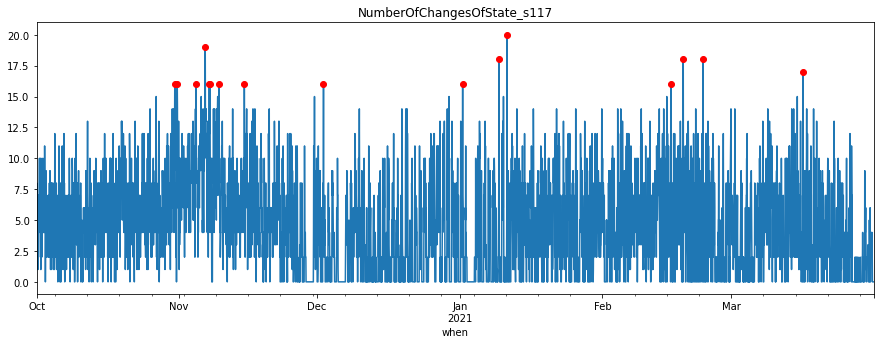

In [13]:
ax = plt.gca()
NumberOfChangesOfState_s117.plot(figsize=(15,5), title="NumberOfChangesOfState_s117", ax=ax)
salientPoints_s117.plot(style="ro",figsize=(15,5), ax=ax)
plt.show()

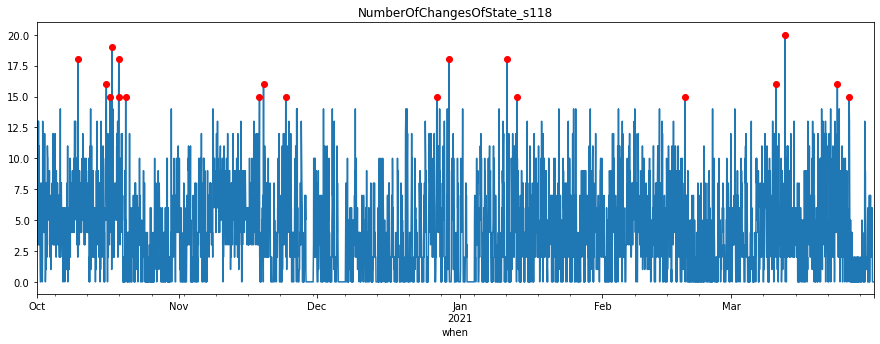

In [14]:
ax = plt.gca()
NumberOfChangesOfState_s118.plot(figsize=(15,5),title="NumberOfChangesOfState_s118", ax=ax)
salientPoints_s118.plot(style="ro",figsize=(15,5), ax=ax)
plt.show()

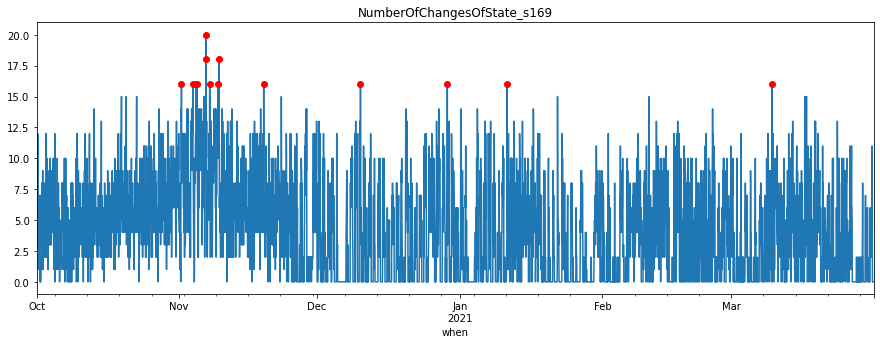

In [15]:
ax = plt.gca()
NumberOfChangesOfState_s169.plot(figsize=(15,5),title="NumberOfChangesOfState_s169",ax=ax)
salientPoints_s169.plot(style="ro",figsize=(15,5), ax=ax)
plt.show()

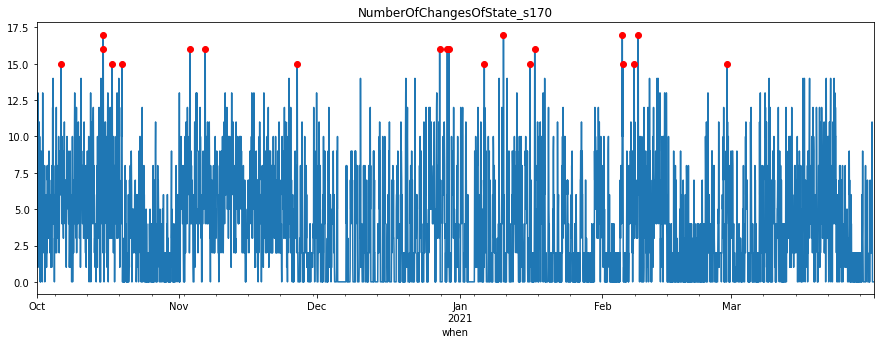

In [16]:
ax = plt.gca()
NumberOfChangesOfState_s170.plot(figsize=(15,5),title="NumberOfChangesOfState_s170", ax=ax)
salientPoints_s170.plot(style="ro",figsize=(15,5), ax=ax)
plt.show()

### Anomaly Detection 1: Task 2

Identify some possible correlations between the higher frequency of turning on/off of the engines, and the other variables. There are some patterns?

We can reframe the problem as a control theory exercise. We analyze these sensors:

- S46: Recovery Water inlet °C 1 decimal


- S109: Discharge Temperature C1,1 °C 1 decimal


- P17: Set-point Heating °C 1 decimal

The work executed by the AC is controlled by PID that based on the temeperate sensor's data control the switch on/off of the motors. A bad configuration of these PID and of the set point that needs to be reached may create an unstable system that can not reach the assigned temperature.

In order to demonstrate this thesis we can observe that the trend of the sensors S46, S109 with respect to P17 (the set point heating).

In [17]:
dataTask2 = df[(df["metric"]=='S46')|(df["metric"]=='S109')|(df["metric"]=='P17')]
groupby_task2 = dataTask2.set_index("when").groupby("metric").apply(lambda df: df.resample("1min").mean().dropna()).compute()

<ipython-input-17-55b6a19f4417>:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  groupby_task2 = dataTask2.set_index("when").groupby("metric").apply(lambda df: df.resample("1min").mean().dropna()).compute()


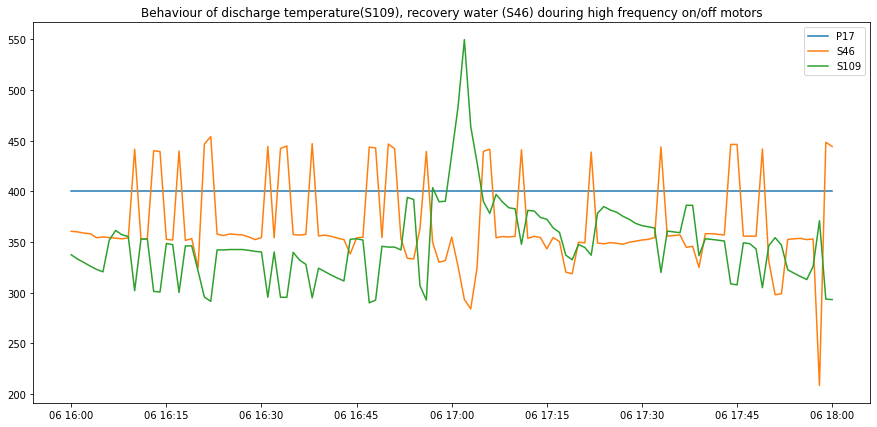

In [18]:
plt.figure(figsize=(15,7))
plt.title("Behaviour of discharge temperature(S109), recovery water (S46) douring high frequency on/off motors")
plt.plot(groupby_task2.loc['P17']["2020-11-06 16:00:00":"2020-11-06 18:00:00"],label="P17")
plt.plot(groupby_task2.loc['S46']["2020-11-06 16:00:00":"2020-11-06 18:00:00"], label="S46")
plt.plot(groupby_task2.loc['S109']["2020-11-06 16:00:00":"2020-11-06 18:00:00"], label="S109")
plt.legend()

We can see that in the moment of the anomaly, the temperature of S46 have an oscillatory behavior in the range of the set point, this abrupt behavior could determinate the fast switch of the motors.

![PID](img/PID.jpeg)